# Nodal deformation due to Dirac's Delta

This program takes a mesh, a set of points and a set of forces assigned to each force. The idea behind this program is to apply a resized Dirac's Delta to every node, so that each force is only applied to one node.

As opposed to the subdomain approach, this approach works for both structured and unstructured meshes, however, it takes a very, very long time to run, which makes it quite impractical.

In [ ]:
#Setup FeniCs

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


In [ ]:
pip install meshio

In [3]:
import meshio

In [5]:
from dolfin import *

In [ ]:
from dolfin import*
import numpy as np

msh = meshio.read("mesh (13).xml")
meshio.write("mesh.xml",msh)
mesh = Mesh("mesh.xml")



Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

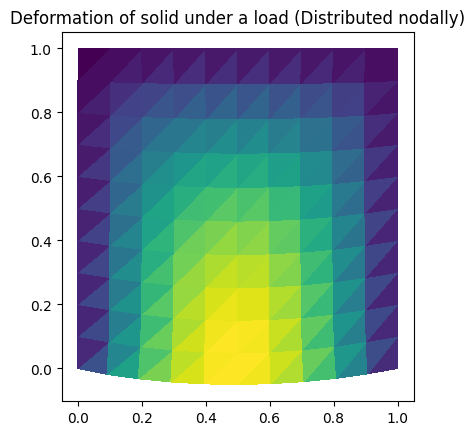

In [16]:
import numpy as np
from dolfin import *

"""
msh = meshio.read("mesh (13).xml")
meshio.write("mesh.xml",msh)
mesh = Mesh("mesh.xml")
"""
mesh = UnitSquareMesh(10,10) #Define example mesh


V = VectorFunctionSpace(mesh, 'Lagrange', degree=1)

#Class that defines a Dirac's Delta.
#Note that two Deltas are defines, one for the x component of the force and one for the y component
class Delta(UserExpression):
    def __init__(self, eps, x0, scale_x, scale_y, **kwargs):
        self.eps = eps
        self.x0 = x0
        self.scale_x = scale_x
        self.scale_y = scale_y
        UserExpression.__init__(self, **kwargs)

    def eval(self, values, x):
        eps = self.eps
        dist_squared = np.linalg.norm(x - self.x0)**2 + eps**2
        values[0] = self.scale_x * eps * abs((x[0] - self.x0[0])) / (pi * dist_squared) #Continous definition for Dirac's Delta
        values[1] = self.scale_y * eps * abs((x[1] - self.x0[1])) / (pi * dist_squared)

    def value_shape(self):
        return (2, )


points = mesh.coordinates()
forces = [[0, -20/len(points)]]*len(points) #Example force, change for needed

# Create a list of Delta expressions for each point and force. Scale value tunes the Delta into the value wished for the force
deltas = [Delta(eps=1E-4, x0=point, scale_x=force[0]*19200, scale_y=force[1]*19200, degree=5)
          for point, force in zip(points, forces)]

#Solves a classical linear elasticity problem
def eps(v):
    return sym(grad(v))

E = Constant(100)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

du = TrialFunction(V)
u_ = TestFunction(V)

a = inner(sigma(du), eps(u_))*dx

# Summation of forces
l = sum(inner(delta, u_)*dx for delta in deltas)

def left(x, on_boundary):
    return on_boundary and (near(x[1], 1) or near(x[0],0) or near(x[0],1)   )

bc = DirichletBC(V, Constant((0., 0.)), left)

u = Function(V, name="Displacement")
solve(a == l, u, bc)

a = plot(u, mode="displacement", title = "Deformation of solid under a load (Distributed nodally)")
